In [1]:
import numpy as np
import json
import glob, os
import json

from ast import literal_eval
from U2Dose.dicomio.rtstruct import RtStruct
from U2Dose.patient.Roi import Roi
from U2Dose.geometry.Grid3D import Grid3D
from MRLCinema.create_margin import create_margin

patient_data_root = r'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
patient_data_root_archive = r'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA_Archive'

output_root = r'/mnt/P/TERAPI/FYSIKER/David_Tilly/DosePrediction/MarginSimulation/rois_predicted_doses'


In [6]:
def find_ctv_name(names:list) -> str:
    ctvs = []
    for name in names:
        if name.startswith('CTV'):
            ctvs.append(name)
    
    if len(ctvs) == 1:
        return ctvs[0]
    elif len(ctvs) > 1:
        raise ValueError(f'Multiple CTVs found: {ctvs}')
    
    raise ValueError(f'No CTVs found: {ctvs}')

def find_grid(bounding_box):
    pos_000 = np.array(bounding_box[0]) - 40
    pos_nnn = np.array(bounding_box[1]) + 40    

    spacing = np.array([1., 1., 1.])
    dim = ((pos_nnn - pos_000) / spacing).astype(int)

    for i in range(3):
        if dim[i] <= 120:
            n_add = (120 - dim[i] + 1) // 2
            dim[i] += 2 * n_add
            pos_000[i] -= n_add * spacing[i]
            
    grid = Grid3D(pos_000, spacing, dim)
    return grid
     

In [ ]:
#
# Read all treatments that will be part of simulation
#
treatments_str = None
with open('../treatment_info_late.json', "r") as f:
    treatments_str = json.load(f)  
treatments = {literal_eval(key): literal_eval(value) for key, value in treatments_str.items()} 

ptv_margin = np.array([4, 5, 5])

#
# Create CTV and PTV for all treatments, write to directory
#
hit = 0
miss = 0
for key, value in treatments.items():
    
    try:
        patient_id = key[0]
        plan_label = key[1]
        print(f'Processing patient {patient_id}, plan {plan_label} START')

        rtss_files = glob.glob(os.path.join(patient_data_root, patient_id, plan_label, 'RS*.dcm'))
        rtss_files.extend(glob.glob(os.path.join(patient_data_root_archive, patient_id, plan_label, 'RS*.dcm')))
        if rtss_files == []:
            print(f'No RTSS found for patient {patient_id}, plan {plan_label}, skipping...')
            continue

        rtss = RtStruct(rtss_files[0])
        rtss.parse()

        ctv_name = find_ctv_name(rtss.all_roi_names())
        if ctv_name == None:
            continue

        #bbox = rtss.bounding_box_from_roi_list([ctv_name, 'Bladder', 'Rectum'])
        #pos_000 = np.array(bbox[0]) - 10
        #pos_nnn = np.array(bbox[1]) + 10
    
        bbox = rtss.bounding_box_from_roi_list([ctv_name])
        grid = find_grid(bbox)
        
        ctv = Roi.from_rtstruct(rtss, ctv_name, grid)
        bladder = Roi.from_rtstruct(rtss, 'Bladder', grid)
        rectum = Roi.from_rtstruct(rtss, 'Rectum', grid)

        # create ptv
        ptv_mask = create_margin(ctv.mask, ctv.spacing, ptv_margin)

        # dump ctv and ptv masks
        np.savez_compressed(os.path.join(output_root, f'CTV_{patient_id}_{plan_label}.npz'), ctv.mask)
        np.savez_compressed(os.path.join(output_root, f'PTV_{patient_id}_{plan_label}.npz'), ptv_mask)
        np.savez_compressed(os.path.join(output_root, f'Bladder_{patient_id}_{plan_label}.npz'), bladder.mask)
        np.savez_compressed(os.path.join(output_root, f'Rectum_{patient_id}_{plan_label}.npz'), rectum.mask)

        with open(os.path.join(output_root, f'grid_{patient_id}_{plan_label}_grid.json'), 'w') as f:
            json.dump({
                'pos_000': ctv.pos_000.tolist(),
                'spacing': ctv.spacing.tolist(),
                'dim': ctv.dim.tolist()
            }, f)

        hit += 1
        print(f'Processing patient {patient_id}, plan {plan_label} END hit:{hit}, miss:{miss}, ctv_volume:{np.sum(ctv.mask)}, ptv_volume:{np.sum(ptv_mask)}')
        print()
        

    except Exception as e:
        print(f'Error processing patient {patient_id}, plan {plan_label}: {e}')
        miss += 1

print(f'Total hits: {hit}, Total misses: {miss}')

Processing patient 193211030873, plan 10MRL1ADT01 START
Processing patient 193211030873, plan 10MRL1ADT01 END hit:1, miss:0, ctv_volume:80662.0, ptv_volume:147761

Processing patient 193211030873, plan 10MRL1ADT02 START


In [ ]:
patient_id = '193211030873'
plan_label = '10MRL1ADT01'  
with open(os.path.join(output_root, f'grid_{patient_id}_{plan_label}_grid.json'), 'r') as f:
    grid_info = json.load(f)
    print(grid_info)
    print(f"pos_000: {grid_info['pos_000']}")

{'pos_000': [-15.3, -80.8, -81.5], 'spacing': [1.0, 1.0, 1.0], 'dim': [92, 178, 134]}
pos_000: [-15.3, -80.8, -81.5]


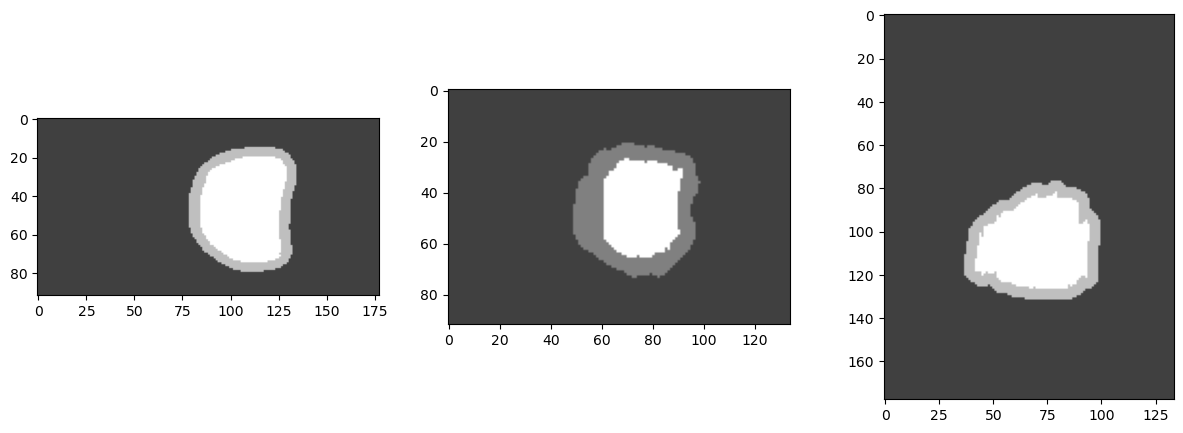

In [ ]:
import matplotlib.pyplot as plt

patient_id = '193211030873'
plan_label = '10MRL1ADT01'
ctv_mask = np.load(os.path.join(output_root, f'CTV_{patient_id}_{plan_label}.npz'))['arr_0']
ptv_mask = np.load(os.path.join(output_root, f'PTV_{patient_id}_{plan_label}.npz'))['arr_0']

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(ctv_mask[:, :, ctv_mask.shape[2]//2], cmap='gray',alpha=0.5)
ax1.imshow(ptv_mask[:, :, ptv_mask.shape[2]//2], cmap='gray', alpha=0.5)

ax2.imshow(ptv_mask[:, ptv_mask.shape[1]//2,:], cmap='gray', alpha=0.5)
ax2.imshow(ctv_mask[:, ctv_mask.shape[1]//2,:], cmap='gray', alpha=0.5)

ax3.imshow(ctv_mask[ctv_mask.shape[0]//2, :, :], cmap='gray', alpha=0.5)
ax3.imshow(ptv_mask[ptv_mask.shape[0]//2], cmap='gray', alpha=0.5)

